In [1]:
# https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task
import mediapipe as mp
import numpy as np
from mediapipe.framework.formats import landmark_pb2
import cv2

In [2]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

model_path = 'hand_landmarker.task'

# options for landmarker in image mode:
options = mp.tasks.vision.HandLandmarkerOptions(
    base_options=mp.tasks.BaseOptions(model_asset_path=model_path),
    running_mode=mp.tasks.vision.RunningMode.IMAGE,
    min_hand_detection_confidence = 0.2,
    min_hand_presence_confidence = 0.2,
    min_tracking_confidence = 0.2,
    # num_hands=2
)

def close(landmarker):
  landmarker.close()

In [5]:
# Only for livestream results
def get_result(result: mp.tasks.vision.HandLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
    return result
    # print(f'hand landmarker result: {result}') 



In [6]:
def draw_landmarks_on_image(rgb_image, detection_result: mp.tasks.vision.HandLandmarkerResult):
    """Courtesy of https://github.com/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb"""
    global first
    try:
        if detection_result.hand_landmarks == []:
            return rgb_image
        else:
            hand_landmarks_list = detection_result.hand_landmarks
            annotated_image = np.copy(rgb_image)
            
            # Loop through the detected hands to visualize.
            for idx in range(len(hand_landmarks_list)):
                print(hand_landmarks_list[idx])
                hand_landmarks = hand_landmarks_list[idx]
                # Draw the hand landmarks.
                hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
                hand_landmarks_proto.landmark.extend([
                    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks])
                mp.solutions.drawing_utils.draw_landmarks(
                    annotated_image,
                    hand_landmarks_proto,
                    mp.solutions.hands.HAND_CONNECTIONS,
                    mp.solutions.drawing_styles.get_default_hand_landmarks_style(),
                    mp.solutions.drawing_styles.get_default_hand_connections_style())
                
            return annotated_image
    except Exception as e:
        print(e, 'exception')
        return rgb_image

In [7]:
def detect(image, clazz, landmarker):
    return (landmarker.detect(image=image), clazz)

In [8]:
# load the landmarker
landmarker = mp.tasks.vision.HandLandmarker.create_from_options(options)

# load image
image = mp.Image.create_from_file('./../data/American Sign Language Letters.v1-v1.tensorflow/train/M18_jpg.rf.129826d37d00c7e46376752d8649edaa.jpg')

# detect result to draw detected keypoints on frame
detection_result = detect(image, 'A', landmarker)
image_with_landmarks = draw_landmarks_on_image(image.numpy_view(), detection_result[0])

# show frame with keypoints drawn
cv2.imshow('Image', image_with_landmarks)

# stop!
cv2.waitKey(0)
        
close(landmarker)
cv2.destroyAllWindows()

[NormalizedLandmark(x=0.4512462019920349, y=0.617003858089447, z=-9.345626494905446e-08, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4895455539226532, y=0.5841653943061829, z=-0.02537473477423191, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.49552541971206665, y=0.5283669233322144, z=-0.0440327487885952, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4417549967765808, y=0.500371515750885, z=-0.06216554343700409, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.392568439245224, y=0.48378100991249084, z=-0.07727140933275223, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4785412847995758, y=0.4663335978984833, z=-0.026575973257422447, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4938638508319855, y=0.4249555766582489, z=-0.06438104063272476, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5115575790405273, y=0.46216434240341187, z=-0.08786612749099731, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5188908576965332, y=0.50019723

In [9]:
def get_keypoints(landmarker, base_path, file_name, clazz):
    image = mp.Image.create_from_file(base_path + file_name)
    return detect(image, clazz, landmarker)

In [18]:
def create_coord_list(detected_landmarks):
  coord_list = []
  for i in detected_landmarks:
    coord_list.append([i.x, i.y, i.z])
  return coord_list
    
def orthonormal_basis_from_triangle(p1, p2, p3):
    """Return orthonormal triad (e1,e2,e3): e1 along (p2-p1), e2 in the plane, e3 = normal."""
    u = p2 - p1
    v = p3 - p1
    n = np.cross(u, v)
    if np.linalg.norm(n) < 1e-12:
        raise ValueError("Anchor points are collinear; cannot define a plane.")
    e1 = u / np.linalg.norm(u)
    v_perp = v - np.dot(v, e1) * e1
    e2 = v_perp / np.linalg.norm(v_perp)
    e3 = np.cross(e1, e2)  # already unit
    return e1, e2, e3

def solve_affine2d(src_xy, dst_xy):
    """Solve 2D affine mapping (x,y)->(X,Y) from 3 point pairs. Returns 2x2 M and 2-dim t."""
    A, b = [], []
    for (x, y), (X, Y) in zip(src_xy, dst_xy):
        A.append([x, y, 1, 0, 0, 0])
        A.append([0, 0, 0, x, y, 1])
        b += [X, Y]
    A = np.asarray(A, float)
    b = np.asarray(b, float)
    m11, m12, tx, m21, m22, ty = np.linalg.solve(A, b)
    M = np.array([[m11, m12],
                  [m21, m22]], float)
    t = np.array([tx, ty], float)
    return M, t

def normalize_landmarks(points, anchor_idx=(0,5,17), lambda_normal=1.0):
    """
    Build a 3D affine transform (A,t) so that:
      P[i1] -> (0,0,0), P[i2] -> (0,1,0), P[i3] -> (1,1,0),
    and the plane normal maps to the Z axis with scale lambda_normal.
    Returns transformed points (N,3) and (A,t).
    """
    P = np.asarray(points, float)
    i1, i2, i3 = anchor_idx
    p1, p2, p3 = P[i1], P[i2], P[i3]

    # Local orthonormal basis B = [e1 e2 e3]
    e1, e2, e3 = orthonormal_basis_from_triangle(p1, p2, p3)
    B = np.column_stack([e1, e2, e3])          # world <- local
    BT = B.T                                    # local <- world

    # Local coordinates of anchors (q = BT * (p - p1))
    q1 = BT @ (p1 - p1)                         # ~ (0,0,0)
    q2 = BT @ (p2 - p1)                         # (x2, y2, 0)
    q3 = BT @ (p3 - p1)                         # (x3, y3, 0)

    src_xy = np.vstack([q1[:2], q2[:2], q3[:2]])
    dst_xy = np.array([[0.,0.],[0.,1.],[1.,1.]], float)

    # Exact 2D affine that hits the three targets in XY
    M2, t2 = solve_affine2d(src_xy, dst_xy)

    # Compose full 3x3 local linear map: XY via M2, Z via lambda_normal
    L_local = np.array([[M2[0,0], M2[0,1], 0.0],
                        [M2[1,0], M2[1,1], 0.0],
                        [0.0,      0.0,    lambda_normal]], float)

    # Because q1 = (0,0,0) maps to (0,0,0), t2 should be ~0; keep it for completeness
    t_local = np.array([t2[0], t2[1], 0.0], float)

    # Convert to a single world-space affine: P' = A @ P + t
    # q = BT @ (P - p1);  q' = L_local @ q + t_local;  P' = q'  (targets are in world axes)
    A = L_local @ BT
    t = -L_local @ (BT @ p1) + t_local

    # Apply to all points
    normalized_points = (A @ P.T).T + t

    return normalized_points

In [19]:
def store_result(result, clazz, normalize = False):
    d = {}
    if normalize:
        coords = create_coord_list(result.hand_landmarks[0])
        norm_coords = normalize_landmarks(coords)
        for k in range(len(coords)):
            d[str(k)+'_x'] = norm_coords[k][0]
            d[str(k)+'_y'] = norm_coords[k][1]
            d[str(k)+'_z'] = norm_coords[k][2]
    
    else:
        for k,v in enumerate(result.hand_landmarks[0]):
            d[str(k)+'_x'] = v.x
            d[str(k)+'_y'] = v.y
            d[str(k)+'_z'] = v.z
        
    d['clazz'] = clazz
    # print(d)
    return d
    
    # store result values in dict and add to list

In [11]:
# convert list of dicts to pd.df
def get_data_frame(result_list):
    return pd.DataFrame(result_list)

In [20]:
#!pip install pandas==2.1.4 moet numpy <2 gebruiken voor mediapipe!
import pandas as pd

# create the landmarker
landmarker = mp.tasks.vision.HandLandmarker.create_from_options(options)

data_path = './../data/American Sign Language Letters.v1-v1.tensorflow/'

train_data = pd.read_csv(data_path + 'train/_annotations.csv')
train_data.head()

valid_data = pd.read_csv(data_path + 'valid/_annotations.csv')
valid_data.head()

test_data = pd.read_csv(data_path + 'test/_annotations.csv')
test_data.head()

train_data[:1]
counter = 0

def store_data(data, folder, normalize=False):
    result_list = []
    # loop through images in csv and get results
    for i in range(len(data)):
        values = data[i:i+1][['filename','class']].values[0]
        file_name, clazz = values[0], values[1]
        result = get_keypoints(landmarker, data_path + folder, file_name, clazz)
        if len(result[0].hand_landmarks) > 0:
            result_list.append(store_result(result[0], clazz, normalize))
    return result_list


In [13]:
# Load results into DataFrame
df_train = get_data_frame(store_data(train_data, 'train/'))
df_train.head()

df_valid = get_data_frame(store_data(valid_data, 'valid/'))
df_valid.head()

df_test = get_data_frame(store_data(test_data, 'test/'))
df_test.head()

,0_x,0_y,0_z,1_x,1_y,1_z,2_x,2_y,2_z,3_x,...,18_x,18_y,18_z,19_x,19_y,19_z,20_x,20_y,20_z,clazz
0,0.220413,0.407688,-2.439712e-07,0.244301,0.368203,-0.045710,0.274913,0.339824,-0.079545,0.289752,...,0.336817,0.531853,-0.084897,0.344718,0.555064,-0.090275,0.361925,0.579921,-0.086742,J
1,0.172257,0.550705,1.030529e-06,0.338433,0.565231,0.000291,0.450155,0.578939,-0.082049,0.520085,...,0.331130,0.584223,-0.407608,0.324186,0.609010,-0.361784,0.292037,0.568101,-0.332374,Q
2,0.334457,0.794290,-8.154910e-07,0.412883,0.802869,-0.086064,0.446111,0.792665,-0.147089,0.377033,...,0.157039,0.766298,-0.166351,0.190989,0.804902,-0.147516,0.211290,0.783848,-0.133047,Z
3,0.778658,0.938037,-2.468774e-07,0.633429,1.000039,-0.181511,0.485250,0.941503,-0.275914,0.400028,...,0.580512,0.472373,-0.169636,0.501489,0.439167,-0.191734,0.443189,0.417627,-0.202647,R
4,0.438939,0.679648,-1.535540e-07,0.502375,0.674169,-0.038537,0.556380,0.663930,-0.070069,0.545202,...,0.365494,0.710153,-0.108953,0.375234,0.713004,-0.104165,0.370452,0.693984,-0.102044,Z


In [17]:
# print(df_train.info())
# print(df_valid.info())
# print(df_test.info())

<class 'pandas.core.series.Series'>
RangeIndex: 1298 entries, 0 to 1297
Series name: clazz
Non-Null Count  Dtype 
--------------  ----- 
1298 non-null   object
dtypes: object(1)
memory usage: 10.3+ KB
None
['U' 'K' 'W' ... 'A' 'W' 'S']
(1298, 2)
[ 9  2  1 ...  7 20 14]




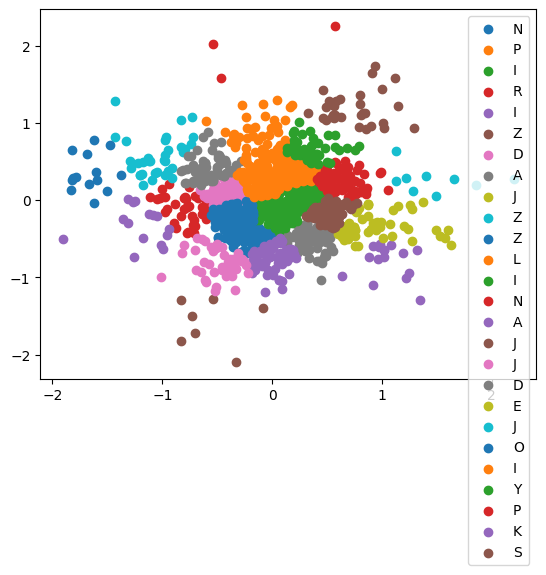

In [15]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statistics import mode

# training features
X_features = ['0_x','0_y','0_z','1_x','1_y','1_z','2_x','2_y','2_z'
                    ,'3_x','3_y','3_z','4_x','4_y','4_z','5_x','5_y','5_z'
                    ,'6_x','6_y','6_z','7_x','7_y','7_z','8_x','8_y','8_z'
                    ,'9_x','9_y','9_z','10_x','10_y','10_z','11_x','11_y','11_z'
                    ,'12_x','12_y','12_z','13_x','13_y','13_z','14_x','14_y','14_z'
                    ,'15_x','15_y','15_z','16_x','16_y','16_z','17_x','17_y','17_z'
                    ,'18_x','18_y','18_z','19_x','19_y','19_z','20_x','20_y','20_z'
]

y_target = 'clazz'

# split into data and targets
df_training_x = df_train[X_features]
df_valid_x = df_valid[X_features]
df_test_x = df_test[X_features]

df_training_y = df_train[y_target]
df_valid_y = df_valid[y_target]
df_test_y = df_test[y_target]

# print information for DataFrame
print(df_training_y.info())
print(df_training_y.values)

# reduce dimensions for plotting and plot 26 clusters
pca = PCA(2)
x = pca.fit_transform(df_training_x.values)
print(x.shape)
kmeans = KMeans(n_clusters=26, random_state=42).fit(x) #for 2 Clusters
print(kmeans.labels_)
print()
print()

#Getting unique labels
unique_labels = np.unique(kmeans.labels_)

# plotting results: 
for i in unique_labels:
    indices = np.where(kmeans.labels_ == i)[0]
    cluster_labels = df_training_y[indices]
    most_common_prediction = mode(cluster_labels.values)
    plt.scatter(x[kmeans.labels_ == i , 0] , x[kmeans.labels_ == i , 1] , label = most_common_prediction)
plt.legend()
plt.show()


In [32]:
# Logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

def train_logistic_regression(X_train, y_train):
    return LogisticRegression(max_iter=500, tol=1e-12).fit(X_train.values, y_train.values)

def test_logistic_regression(model, title, X, y):
    print(f'Statistics: {title}')
    print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y, y_pred=model.predict(X=X.values))))
    print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y, y_pred=model.predict(X=X.values))))
    print(classification_report(y_true=y, y_pred=model.predict(X=X.values)))
    print()

model = train_logistic_regression(df_training_x, df_training_y)
print('model fit in {} iterations'.format(model.n_iter_[0]))
print()
test_logistic_regression(model, 'Training', df_training_x, df_training_y)
test_logistic_regression(model, 'Validation', df_valid_x, df_valid_y)
test_logistic_regression(model, 'Test', df_test_x, df_test_y)


model fit in 295 iterations

Statistics: Training
accuracy: 0.6649
f1: 0.6565
              precision    recall  f1-score   support

           A       0.41      0.75      0.53        64
           B       0.79      0.77      0.78        35
           C       0.79      0.45      0.58        33
           D       0.76      0.56      0.64        50
           E       0.83      0.75      0.78        51
           F       0.80      0.98      0.88        53
           G       0.60      0.90      0.72        49
           H       1.00      0.39      0.56        36
           I       0.74      0.90      0.81        71
           J       0.47      0.63      0.54        71
           K       0.72      0.84      0.78        45
           L       0.64      0.69      0.66        64
           M       0.68      0.33      0.45        45
           N       0.70      0.57      0.62        53
           O       0.69      0.47      0.56        47
           P       0.73      0.56      0.64        39
   

C:\SD\anaconda333\envs\ktai-assignment-3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\SD\anaconda333\envs\ktai-assignment-3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\SD\anaconda333\envs\ktai-assignment-3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# Load normalized results into DataFrame
df_train_normalized = get_data_frame(store_data(train_data, 'train/', True))
df_train_normalized.head()

df_valid_normalized = get_data_frame(store_data(valid_data, 'valid/', True))
df_valid_normalized.head()

df_test_normalized = get_data_frame(store_data(test_data, 'test/', True))
df_test_normalized.head()

,0_x,0_y,0_z,1_x,1_y,1_z,2_x,2_y,2_z,3_x,...,18_x,18_y,18_z,19_x,19_y,19_z,20_x,20_y,20_z,clazz
0,-4.440892e-16,4.440892e-16,0.0,-0.236384,0.090737,-0.045319,-0.397406,0.228807,-0.075154,-0.165622,...,1.378048,1.275446,-0.019063,1.604058,1.415672,-0.016589,1.828350,1.589045,-0.002881,J
1,0.000000e+00,-5.551115e-17,0.0,-0.318879,0.206240,0.071910,-0.285244,0.543234,0.132616,-0.133697,...,0.920906,1.177242,0.129969,0.807483,1.037169,0.145758,0.766008,0.954804,0.093303,Q
2,0.000000e+00,0.000000e+00,0.0,-0.228766,0.216007,0.078405,-0.281925,0.448115,0.118868,0.096547,...,1.074313,0.901946,0.066201,0.873876,0.662981,0.085913,0.768716,0.661150,0.064426,Z
3,-4.440892e-16,-4.440892e-16,0.0,-0.549436,0.348256,0.091335,-0.526431,0.783704,0.194932,-0.171903,...,1.290703,1.469281,0.072216,1.360541,1.651877,0.135644,1.411522,1.770191,0.184458,R
4,4.440892e-16,0.000000e+00,0.0,-0.256589,0.130031,0.047090,-0.479864,0.262637,0.082818,-0.313620,...,0.818338,0.670696,0.064583,0.743109,0.604676,0.066883,0.763282,0.703596,0.051676,Z


In [22]:
# prepare data for training
df_training_normalized_x = df_train_normalized[X_features]
df_valid_normalized_x = df_valid_normalized[X_features]
df_test_normalized_x = df_test_normalized[X_features]

df_training_normalized_y = df_train_normalized[y_target]
df_valid_normalized_y = df_valid_normalized[y_target]
df_test_normalized_y = df_test_normalized[y_target]


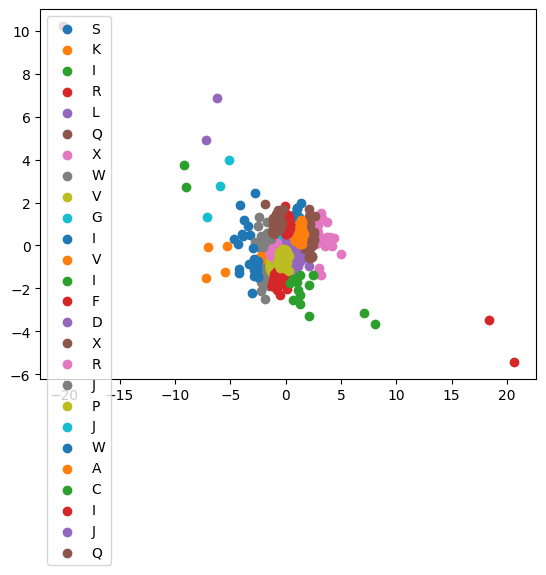

In [23]:
# test cluster on normalized training data
x_normalized = pca.fit_transform(df_training_normalized_x.values)
kmeans_normalized = KMeans(n_clusters=26, random_state=42).fit(x_normalized) # for 26 Clusters

#Getting unique labels
unique_labels_normalized = np.unique(kmeans_normalized.labels_)

# plotting results: 
for i in unique_labels_normalized:
    indices = np.where(kmeans_normalized.labels_ == i)[0]
    cluster_labels_normalized = df_training_normalized_y[indices]
    most_common_prediction_normalized = mode(cluster_labels_normalized.values)
    plt.scatter(x_normalized[kmeans_normalized.labels_ == i , 0] , x_normalized[kmeans_normalized.labels_ == i , 1] , label = most_common_prediction_normalized)
plt.legend()
plt.show()

In [31]:
# test log reg model on normalized data and compare results
model = train_logistic_regression(df_training_normalized_x, df_training_normalized_y)
print('model fit in {} iterations'.format(model.n_iter_[0]))
print()
test_logistic_regression(model, 'Training', df_training_normalized_x, df_training_normalized_y)
test_logistic_regression(model, 'Validation', df_valid_normalized_x, df_valid_normalized_y)
test_logistic_regression(model, 'Test', df_test_normalized_x, df_test_normalized_y)

# TODO look at ConvergenceWarning

model fit in 500 iterations

Statistics: Training
accuracy: 0.8482
f1: 0.8463
              precision    recall  f1-score   support

           A       0.71      0.91      0.79        64
           B       0.85      1.00      0.92        35
           C       0.79      0.82      0.81        33
           D       0.84      0.82      0.83        50
           E       0.87      0.94      0.91        51
           F       1.00      0.98      0.99        53
           G       0.88      0.94      0.91        49
           H       0.89      0.92      0.90        36
           I       0.83      0.92      0.87        71
           J       0.84      0.58      0.68        71
           K       0.98      0.91      0.94        45
           L       0.91      0.91      0.91        64
           M       0.93      0.84      0.88        45
           N       0.86      0.83      0.85        53
           O       0.67      0.83      0.74        47
           P       0.77      0.85      0.80        39
   

C:\SD\anaconda333\envs\ktai-assignment-3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
# test random forest model
from sklearn.ensemble import RandomForestClassifier

# TODO hypertune parameters...
def train_rf_model(X_train, y_train):
    hyperparameters = {
        'n_jobs': -1,
        'criterion': 'log_loss', # {'gini', 'log_loss', 'entropy'}
        'max_depth': 20, # max 26 letters?
        'max_features': 'sqrt', # {'sqrt', 'log2', None }
        'n_estimators': 100, # 10 - 100 (standard=100)
        'random_state': 42,
        'min_samples_leaf': 10, # experiment with values 10 - 50?
        'min_samples_split': 15 # experiment with values 5-20?
        # max_leaf_nodes
        # min_impurity_decrease
        # min_weight_fraction_leaf
    }
    model = RandomForestClassifier(**hyperparameters)
    model.fit(X_train, y_train)
    return model

def test_rf_model(model, title, X, y):
    # y_pred = model.predict_proba(X_test)[:,1]
    print(f'Statistics: {title}')
    print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y, y_pred=model.predict(X=X))))
    print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y, y_pred=model.predict(X=X))))
    print(classification_report(y_true=y, y_pred=model.predict(X=X)))
    

rf_model = train_rf_model(df_training_normalized_x, df_training_normalized_y)
test_rf_model(rf_model, 'Training', df_training_normalized_x, df_training_normalized_y)
test_rf_model(rf_model, 'Validation', df_valid_normalized_x, df_valid_normalized_y)
test_rf_model(rf_model, 'Test', df_test_normalized_x, df_test_normalized_y)

Statistics: Training
accuracy: 0.8875
f1: 0.8896
              precision    recall  f1-score   support

           A       0.77      0.92      0.84        64
           B       0.95      1.00      0.97        35
           C       0.61      0.94      0.74        33
           D       0.78      0.86      0.82        50
           E       0.92      0.92      0.92        51
           F       1.00      0.98      0.99        53
           G       0.88      0.90      0.89        49
           H       0.94      0.94      0.94        36
           I       0.98      0.89      0.93        71
           J       0.81      0.79      0.80        71
           K       1.00      0.91      0.95        45
           L       0.95      0.94      0.94        64
           M       0.95      0.87      0.91        45
           N       0.90      0.85      0.87        53
           O       0.75      0.91      0.83        47
           P       0.82      0.85      0.84        39
           Q       0.85      0.8

C:\SD\anaconda333\envs\ktai-assignment-3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\SD\anaconda333\envs\ktai-assignment-3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\SD\anaconda333\envs\ktai-assignment-3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [65]:
# TODO train neural network
from sklearn.neural_network import MLPClassifier

def train_nn_model(X_train, y_train):
    clf = MLPClassifier(
        solver='adam', 
        alpha=1e-5,
        hidden_layer_sizes=(26, 26), 
        random_state=42,
        max_iter=500
    )
    clf.fit(X_train, y_train)
    return clf

def test_nn_model(model, title, X, y):
    # y_pred = model.predict_proba(X_test)[:,1]
    print(f'Statistics: {title}')
    print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y, y_pred=model.predict(X=X))))
    print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y, y_pred=model.predict(X=X))))
    print(classification_report(y_true=y, y_pred=model.predict(X=X)))

nn_model = train_nn_model(df_training_normalized_x, df_training_normalized_y)
test_nn_model(nn_model, 'Training', df_training_normalized_x, df_training_normalized_y)
test_nn_model(nn_model, 'Validation', df_valid_normalized_x, df_valid_normalized_y)
test_nn_model(nn_model, 'Test', df_test_normalized_x, df_test_normalized_y)

Statistics: Training
accuracy: 0.9060
f1: 0.9061
              precision    recall  f1-score   support

           A       0.84      0.91      0.87        64
           B       1.00      1.00      1.00        35
           C       0.91      0.88      0.89        33
           D       0.86      0.88      0.87        50
           E       1.00      0.86      0.93        51
           F       1.00      0.98      0.99        53
           G       0.92      0.96      0.94        49
           H       0.90      0.97      0.93        36
           I       0.96      0.97      0.97        71
           J       0.76      0.77      0.77        71
           K       0.95      0.91      0.93        45
           L       0.94      0.92      0.93        64
           M       0.93      0.91      0.92        45
           N       0.88      0.87      0.88        53
           O       0.82      0.98      0.89        47
           P       0.87      0.87      0.87        39
           Q       0.81      0.8

C:\SD\anaconda333\envs\ktai-assignment-3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\SD\anaconda333\envs\ktai-assignment-3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\SD\anaconda333\envs\ktai-assignment-3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\SD\anaconda333\envs\ktai-assignment-3\Lib\site-packages\sklearn\metrics\_clas

In [ ]:
# TODO refine clusters Try TSNE? https://www.kaggle.com/code/mikedelong/f1-1-with-logistic-regression